# Проект 5. Компьютер говорит «Нет»

## Описание проекта

Наша задача написать скоринговую модель предсказания дефолта клиентов банка.

Проект выполнил Бердюгин Евгений, DSPR-40

## Описания полей

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

## Загрузка библиотек и данных

In [80]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from datetime import datetime

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.feature_selection import GenericUnivariateSelect, chi2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

import warnings
warnings.simplefilter('ignore')

Загрузим наши датасеты

In [2]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

Зафиксируем Random seed и версию пакетов, для воспроизводимости пакетов

In [3]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

Объединяем датасеты

In [228]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['default'] = 0 # в тесте у нас нет значения Default, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
#сохраним id клиентов, для отправки результатов на Kaggle 
client_id = pd.DataFrame(data['client_id'])
sample = pd.DataFrame(data['sample'])
default = pd.DataFrame(data['default'])
data = data.drop('client_id', axis=1)

#сделаем файл для сравнивания метрик моделей
data_report = pd.DataFrame(columns=['0', '1', 'accuracy', 'macro avg', 'weighted avg'])

## Функции

In [177]:
#Функция определения выбросов
def detect_outliers(data):
    '''Function is called to detect outliers'''
    q1, q3 = np.percentile(sorted(data), [25, 75])

    IQR = q3 - q1

    l_b = q1 - (1.5 * IQR) # lower bound
    u_b = q3 + (1.5 * IQR) # upper bound
    outl_count_low = len(data[data < l_b])
    outl_count_hi = len(data[data > u_b])

    print(
        f'Low Bound: {round(l_b,3)}', 
        f'Up Bound {round(u_b,3)}', 
        f'Outliers low Cnt: {outl_count_low}',
        f'Outliers hi Cnt: {outl_count_hi}'
    )

In [178]:
#функция кросс-валидации, 
def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)

In [179]:
#функция создания признаков из даты
def data_features(data, col):
    data['year'] = data[col].apply(lambda x: x.year)
    
    data['month'] = data[col].apply(lambda x: x.month)
    
    data['day_of_yar'] = data[col].apply(lambda x: x.timetuple()[7])
    
    data['weekday'] = data[col].apply(lambda x: x.weekday())
    
    data['is_weekend'] = data['weekday'].apply(lambda x: 1 if x in (5, 6) else 0)

## EDA

Разведывательный анализ сделан с помощью библиотеки pandasprofiling.
Ссылка на ноутбук [Pandas.profiling_for_Project_5.ipynb](https://github.com/EvgeniyBerdyugin/SkillFactory-dspr-40/blob/main/module_5/Pandas.profiling_for_Project_5.ipynb)

In [180]:
#разделим признаки на категории
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'region_rating','home_address', 'work_address',
            'sna','first_time']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']
date_cols = ['app_date']

Посмотрим выбросы

In [181]:
for col in num_cols:
    print(col)
    detect_outliers(data[col])

age
Low Bound: 3.0 Up Bound 75.0 Outliers low Cnt: 0 Outliers hi Cnt: 0
decline_app_cnt
Low Bound: 0.0 Up Bound 0.0 Outliers low Cnt: 0 Outliers hi Cnt: 18677
income
Low Bound: -22000.0 Up Bound 90000.0 Outliers low Cnt: 0 Outliers hi Cnt: 7000
bki_request_cnt
Low Bound: -4.5 Up Bound 7.5 Outliers low Cnt: 0 Outliers hi Cnt: 2636
score_bki
Low Bound: -3.299 Up Bound -0.529 Outliers low Cnt: 82 Outliers hi Cnt: 436


### Выводы из разведывательного анализа и анализа выбросов:

* app_date преобразовать в datetime
* education заполнить пропуски, преобразовать с помощью LabelEncoding
* sex преобразовать с помощью LabelEncoding
* age смещенное распределение, перевести в категории или логарифмировать
* car и car_type высокая корреляция с car_type, преобразовать с помощью  LabelEncoding, объеденить с car_type
* decline_app_cnt много нулевых значений, много выбросов, перевести в категории или логарифмировать
* good_work все ок
* score_bki есть выбросы, перевести в категорию
* bki_request_cnt много нулевых значений, есть выбросы, перевести в категории или логарифмировать
* region_rating слегка смещенное распределение, преобразовать в более читаемый для модели вид
* home_address и work_address высокая корреляция с work_address, объеденить с work_address
* income смещенное распределение, есть выбросы, перевести в категории или логарифмировать
* sna и first_time высокая корреляция с first_time, объеденить с first_time
* foreign_passport преобразовать с помощью LabelEncoding
* default целевая переменная. Не сбалансированная выборка. Количество одного класса сильно больше количества второго класса.Пробовать веса классов или добавать в выборку больше значений класса меньшинства.

Обработаем даты

In [182]:
for col in date_cols:
    data[col] = pd.to_datetime(data[col])

Заполним пропуски модой

In [183]:
mod_edu = data['education'].mode()
data['education'] = data['education'].fillna(mod_edu[0])

In [184]:
# imp = SimpleImputer(strategy='most_frequent')
# imp.fit(data)

# data = imp.transform(data)

# data = pd.DataFrame(data)

### Обучим наивную модель для сравнения - LogisticRegression на стандартных настойках

In [185]:
data_naive = data[['age',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'sample', 'default']]

In [186]:
# Теперь выделим тестовую часть
train_data = data_naive.query('sample == 1').drop(['sample'], axis=1)
test_data = data_naive.query('sample == 0').drop(['sample'], axis=1)

y = train_data.default.values            # наш таргет
X = train_data.drop(['default'], axis=1)

confusion_matrix
[[12933     0]
 [ 1827     0]]


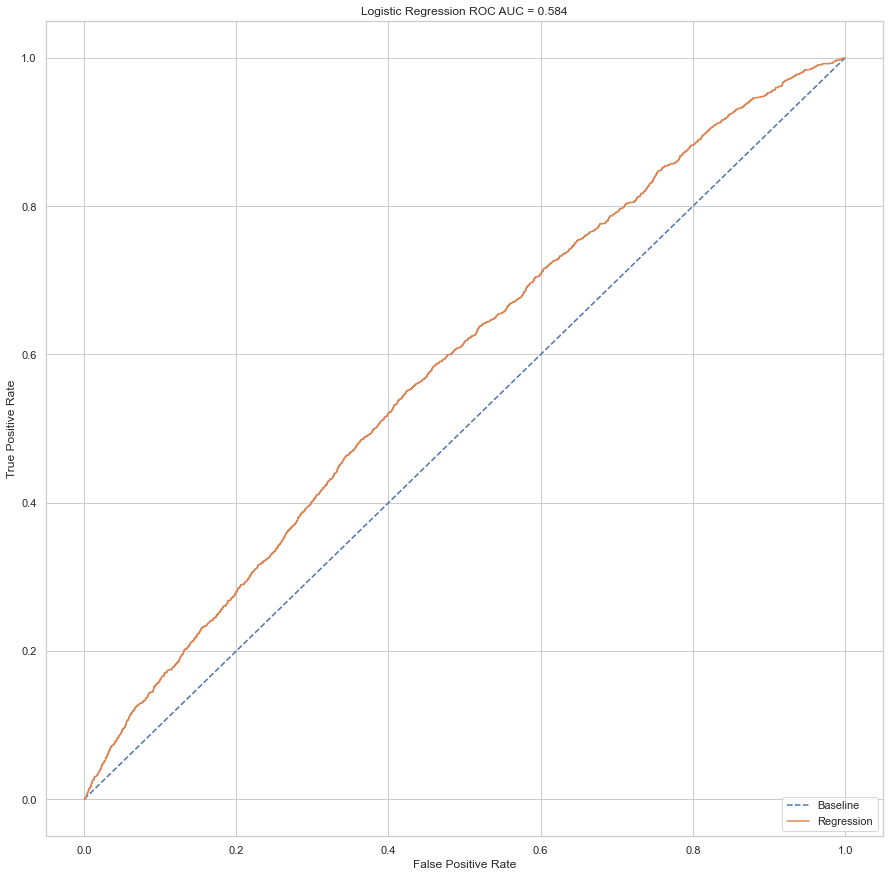

log_loss 0.3695188082814619


,0,1,accuracy,macro avg,weighted avg
naive,-,-,-,-,-
precision,0.87622,0.0,0.87622,0.43811,0.767761
recall,1.0,0.0,0.87622,0.5,0.87622
f1-score,0.934027,0.0,0.87622,0.467013,0.818412
support,12933.0,1827.0,0.87622,14760.0,14760.0


In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('confusion_matrix', confusion_matrix(y_test, y_pred), sep='\n')

probs = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
roc_auc = roc_auc_score(y_test, probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

print('log_loss', log_loss(y_test, probs))

data_report.loc['naive'] = '-'
data_report = data_report.append(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)))
data_report

precision-recall curve наивной модели выглядит лучше, чем если бы мы использовали случайный выбор, однако она все примеры определила в нулевой класс. Такой результат совлем не подходит для скоринговой модели. Будем пробовать ее улучшать.

## Посмотрим распределение логарифмированных числовых переменных

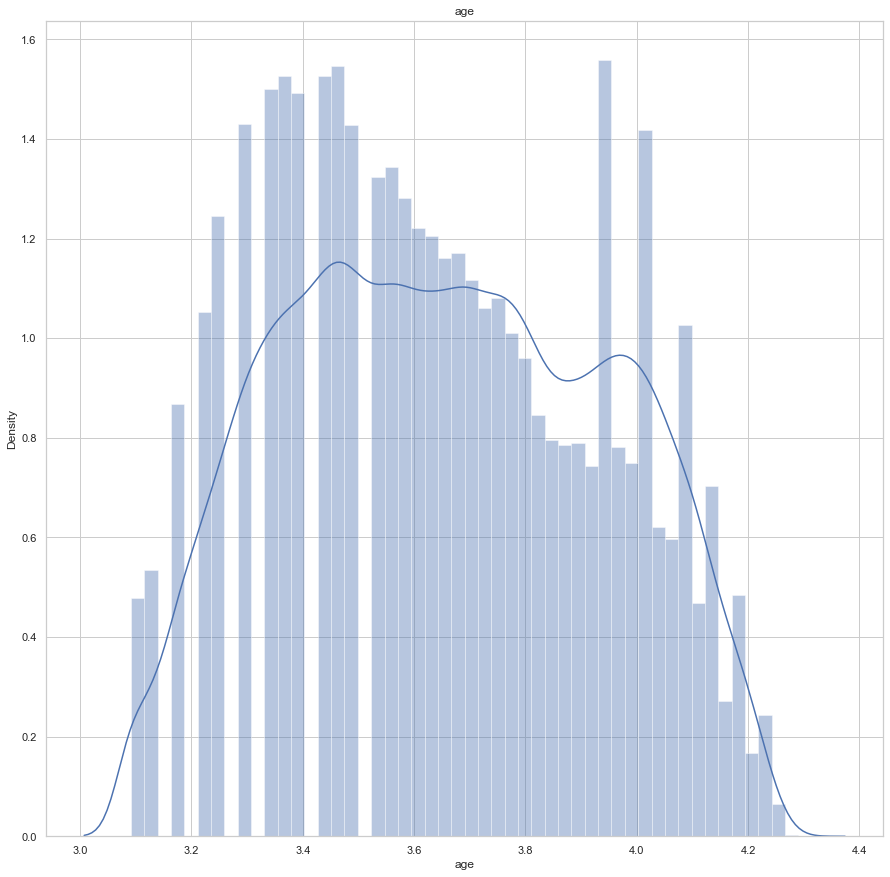

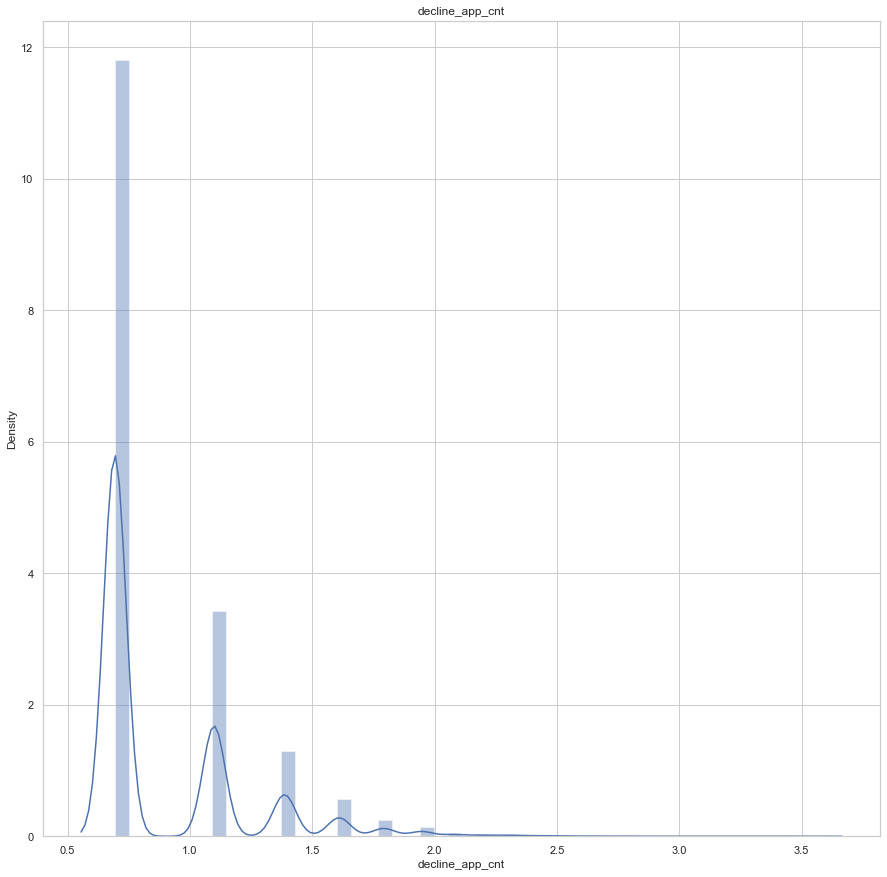

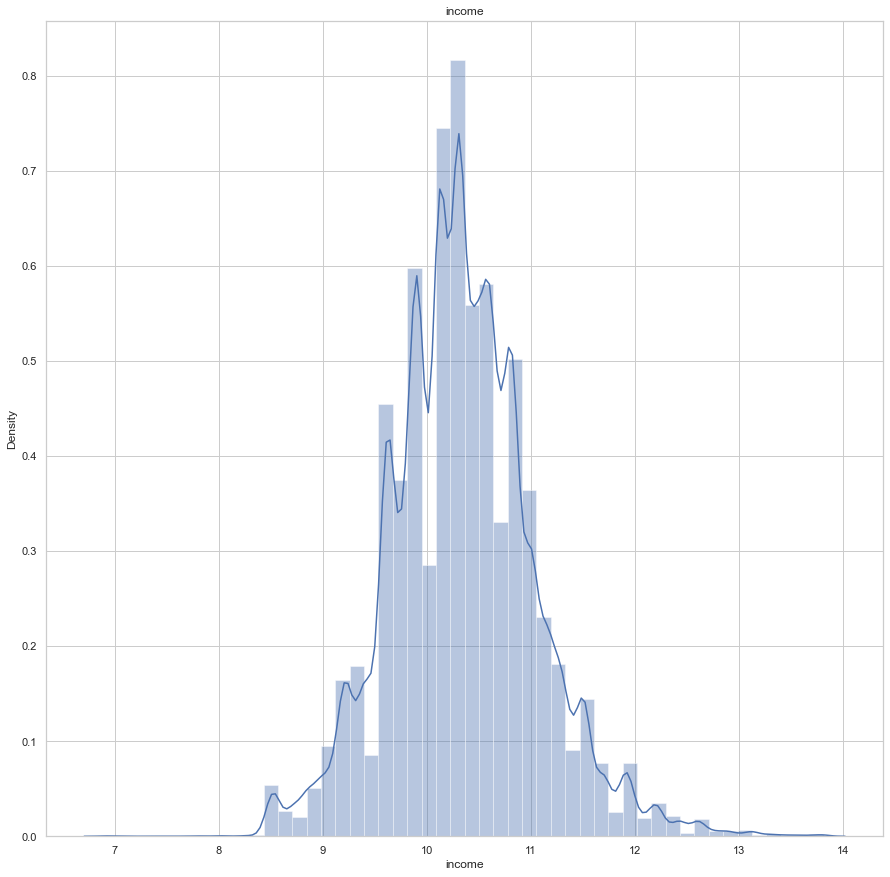

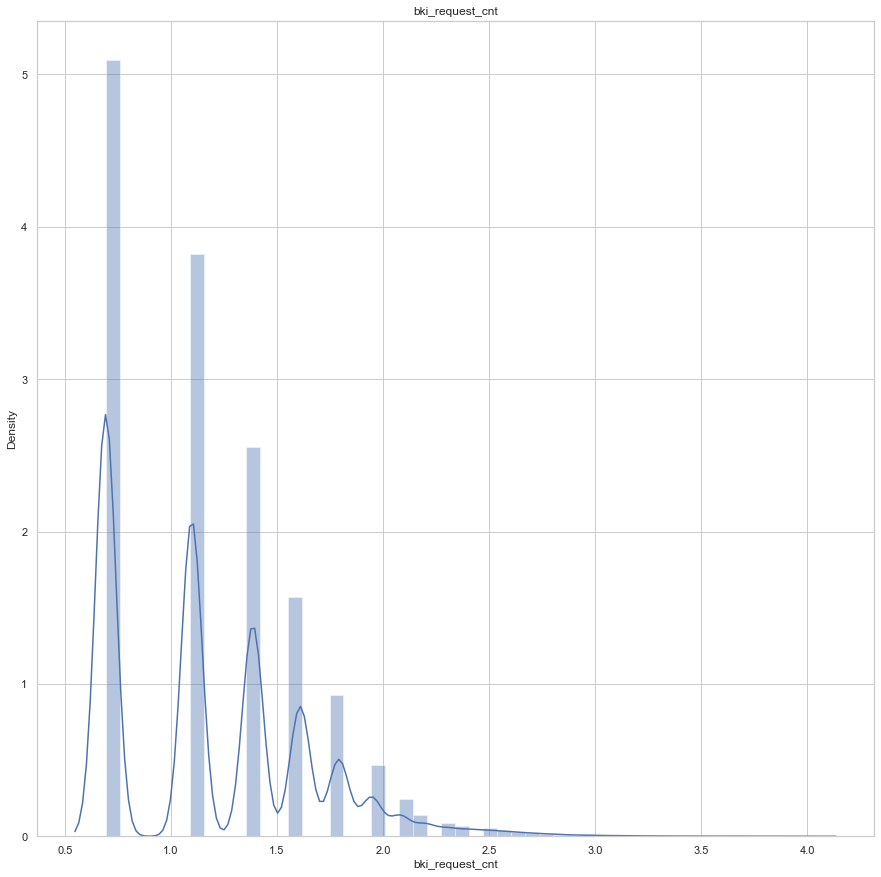

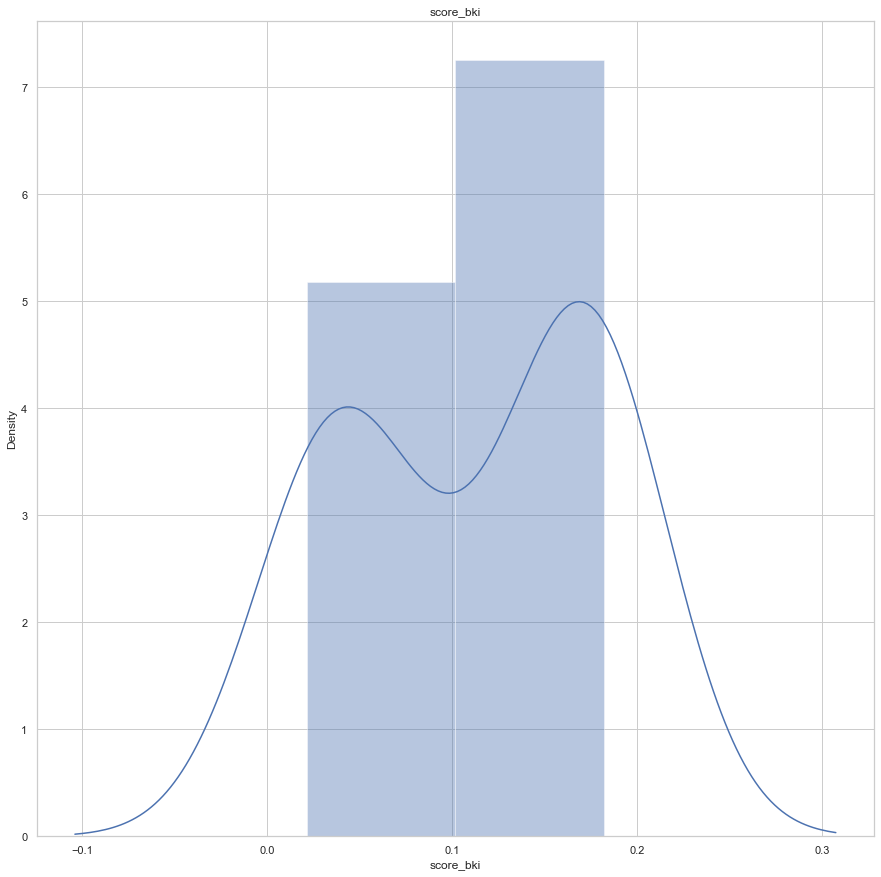

In [188]:
for col in num_cols:
    plt.figure()
    sns.distplot(np.log(data[col][data[col] > 0].dropna() +1))
    plt.title(col)
    plt.show()

income и age приобрели распределение похожее на нормальное, добавим признаки с их логарифмированными значениями

In [189]:
col_for_log = ['income', 'age']
for col in col_for_log:
    data[col+'_log'] =np.log(data[col])
    num_cols.append(col+'_log')

Сделаем категориальный признак из age

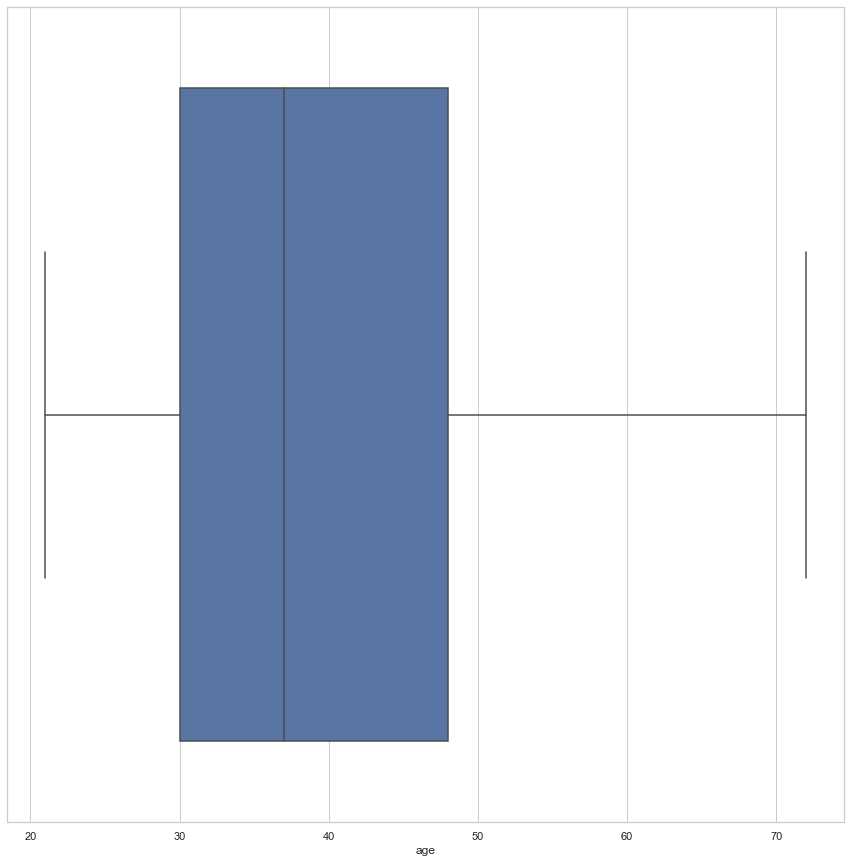

In [190]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=data['age'])
plt.show()

In [191]:
q1, q3 = np.percentile(sorted(data['age']), [25, 75])
data['age_cat'] = data['age'].apply(
    lambda x: 0 if x < q1 else (2 if x > q3 else 1))

посмотрим boxplot числовых признаков

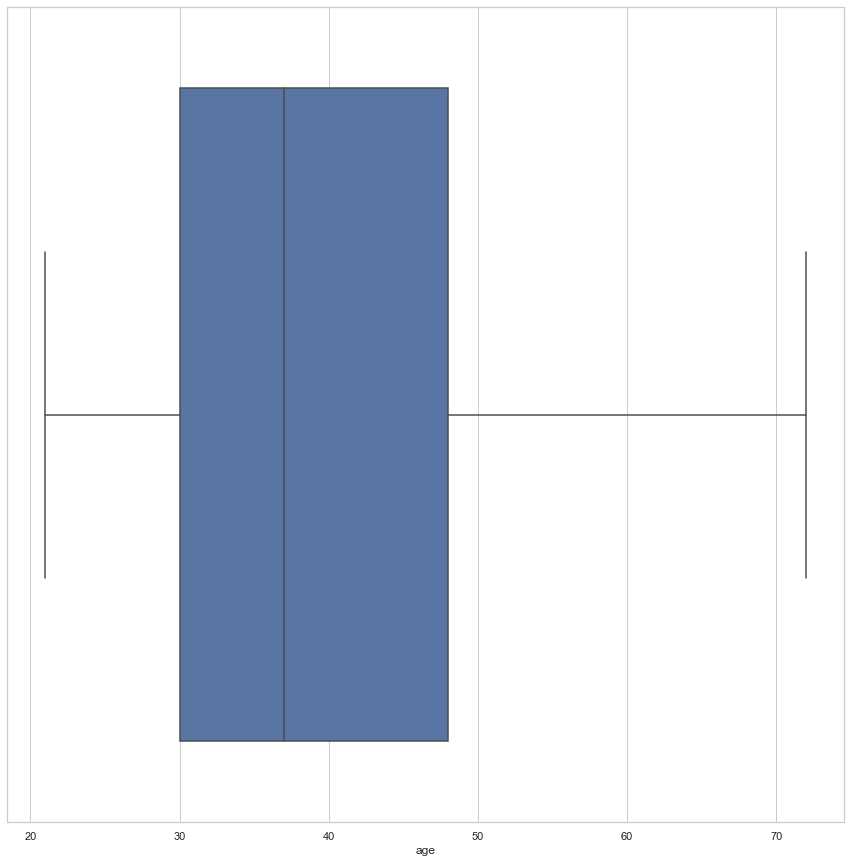

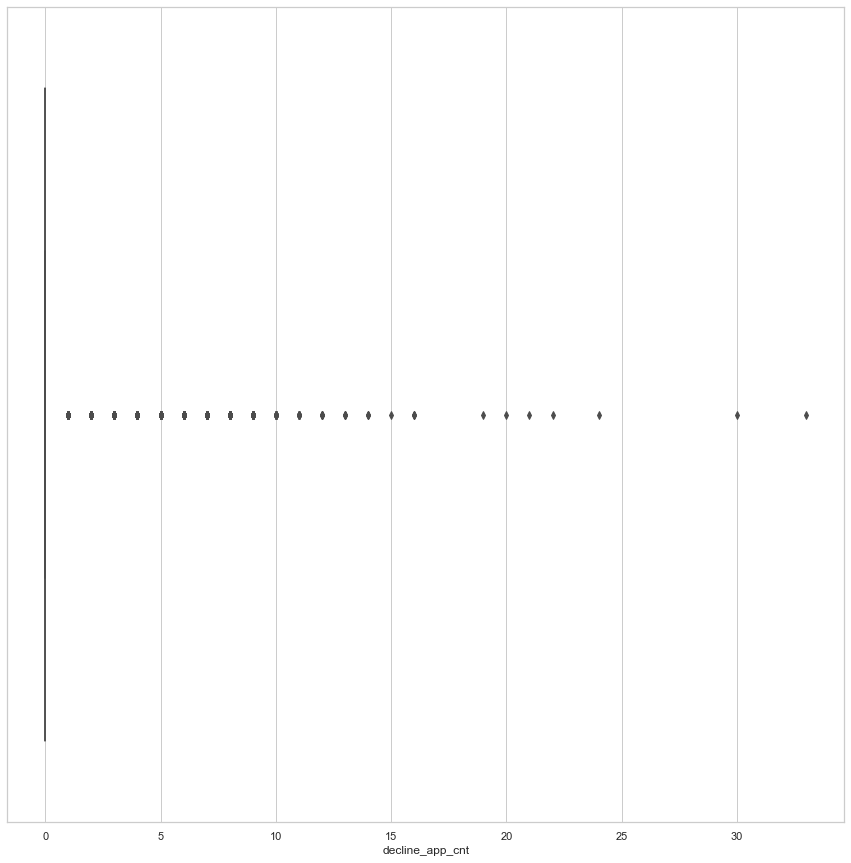

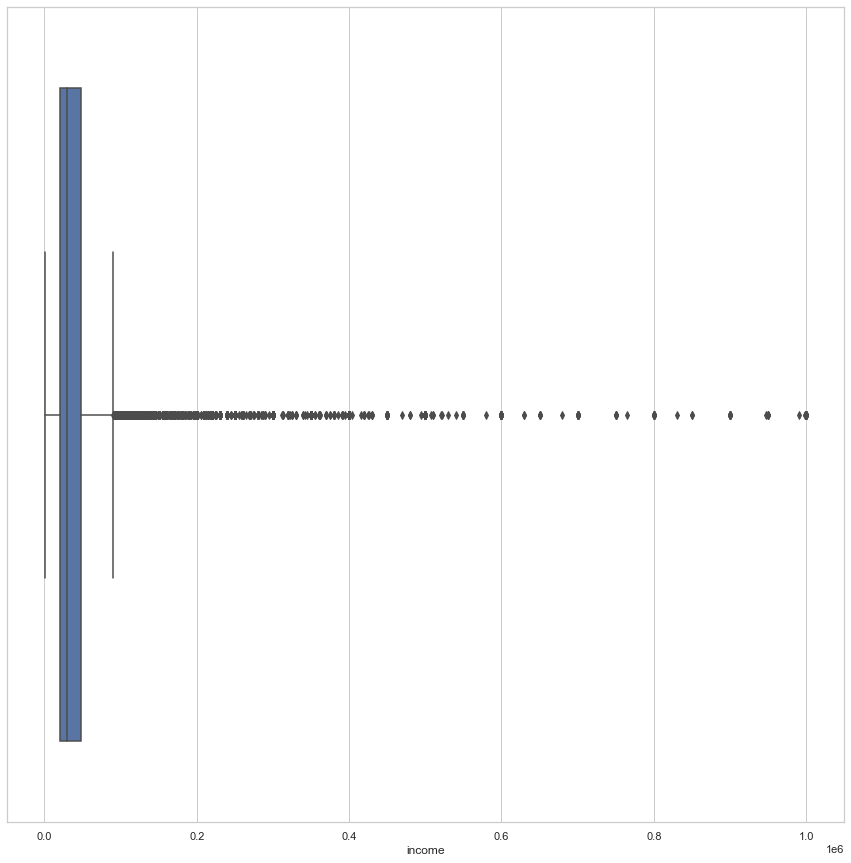

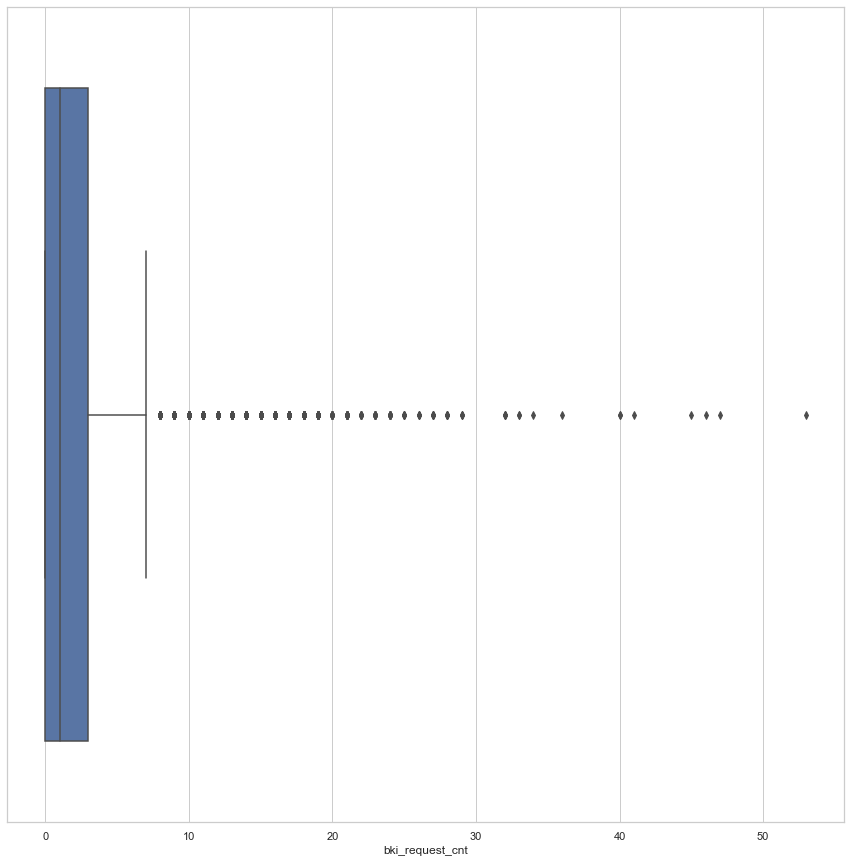

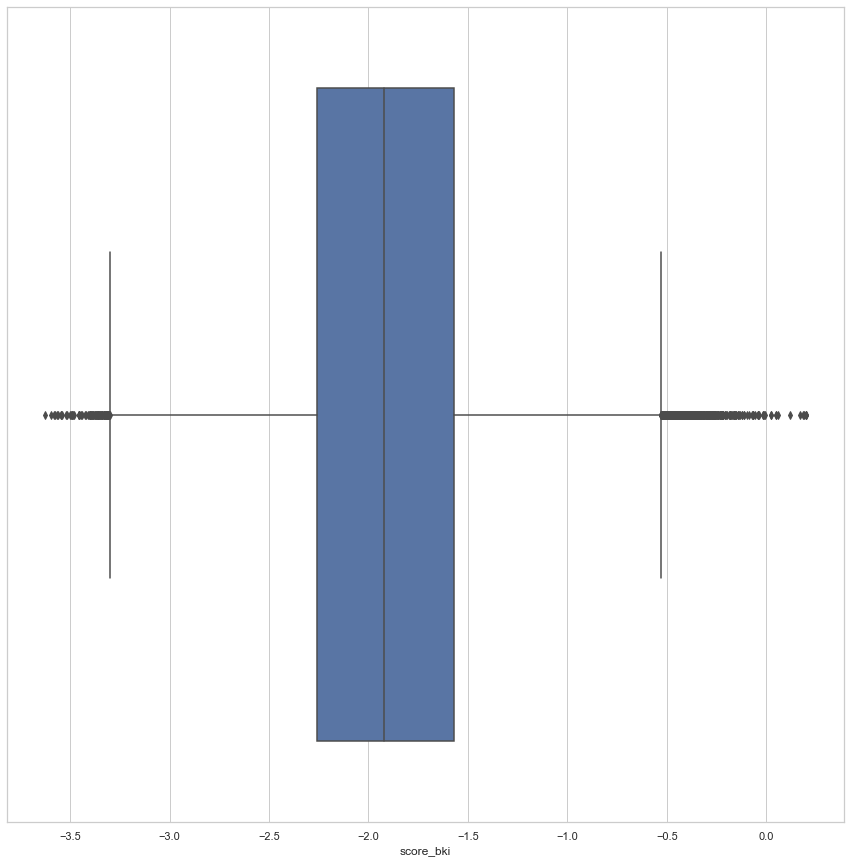

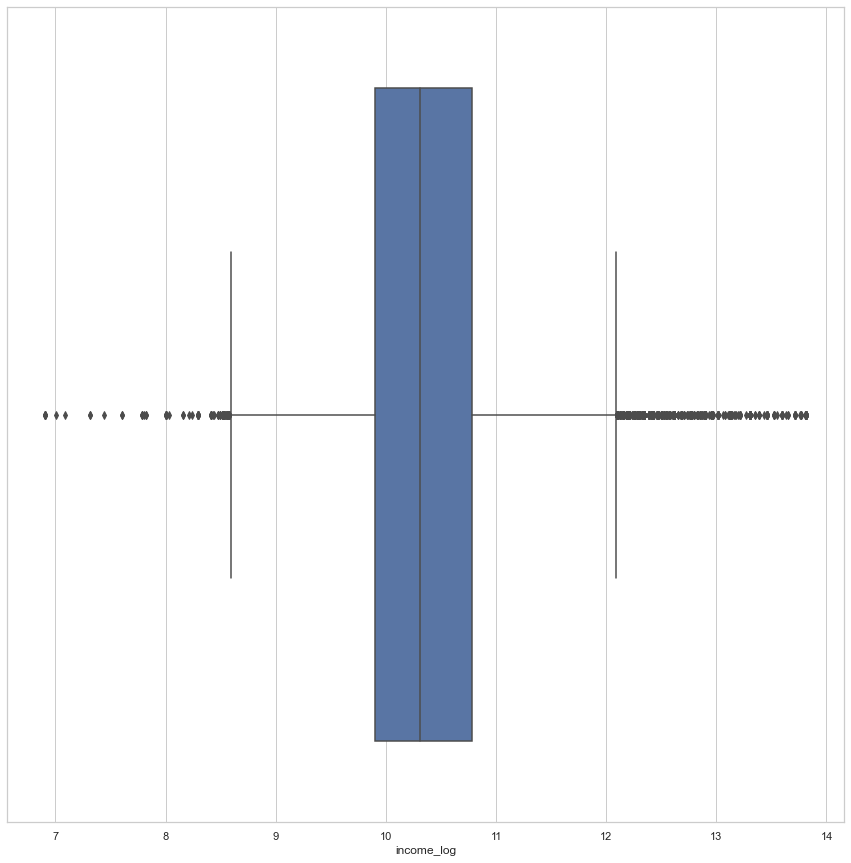

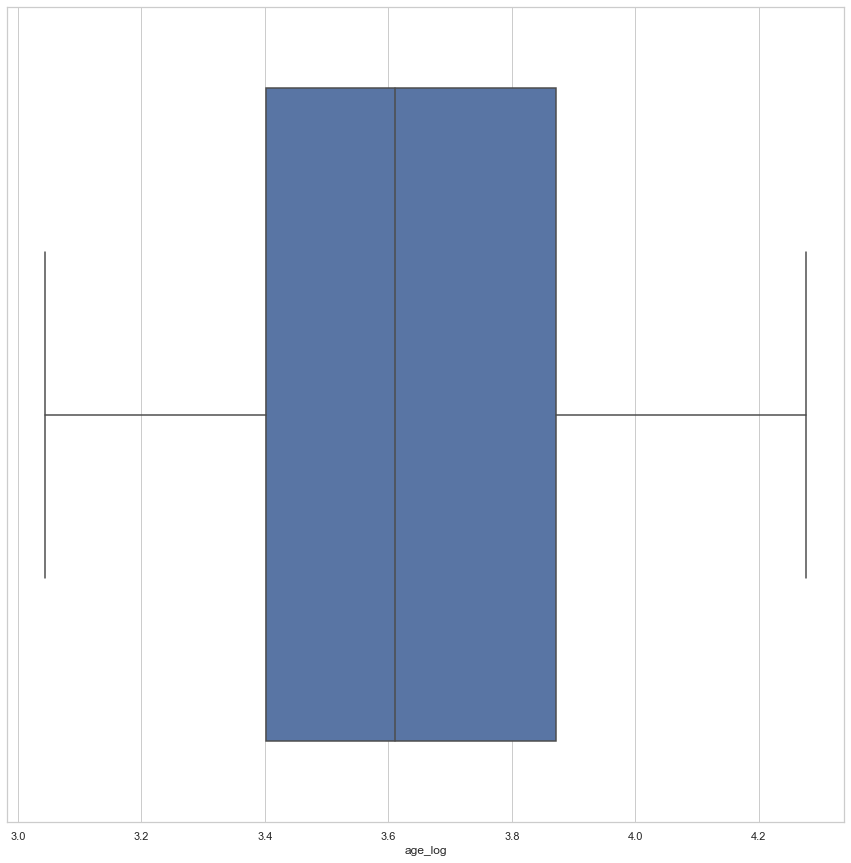

In [192]:
for i in num_cols:
    sns.set_theme(style="whitegrid")
    ax = sns.boxplot(x=data[i])
    plt.show()

decline_app_cnt имеет большинство нулей разделим ее на две категории: были отказы и не было

In [193]:
data['decline_app'] = data['decline_app_cnt'].apply(lambda x: 0 if x == 0 else 1)

income имеет сильное смещение и большое количество выбросов. Разделим ее на три категории low, mid и hi (0, 1, 2)

In [194]:
q1, q3 = np.percentile(sorted(data['income']), [25, 75])
data['income_cat'] = data['income'].apply(
    lambda x: 0 if x < q1 else (2 if x > q3 else 1))

bki_request_cnt имеет большинство значений около 1. Разделим ее на две категории меньше либо равно 1 и больше единицы (0, 1)

In [195]:
data['bki_request'] = data['bki_request_cnt'].apply(lambda x: 0 if x <= 1 else 1)

## Обработаем бинарные признаки

LabelEncoder для sex, foreign_passport, car, car_type

In [196]:
label_encoder = LabelEncoder()
data['sex'] = pd.Series(label_encoder.fit_transform(data['sex']))
data['foreign_passport'] = pd.Series(label_encoder.fit_transform(data['foreign_passport']))
data['car'] = pd.Series(label_encoder.fit_transform(data['car']))
data['car_type'] = pd.Series(label_encoder.fit_transform(data['car_type']))

объединим car  и car_type

In [197]:
data['car_car_type'] = data['car'] + data['car_type']

## Обработаем категориальные признаки

Заменим значения educatoin, значениями от 0 до 4, в зависимости от ранга
образования

In [198]:
data_edu = {'SCH': 0, 'UGR': 1, 'GRD': 2, 'PGR': 3, 'ACD': 4}
data['education'] = data['education'].apply(lambda x: data_edu[x])

Объеденим home_adress и work_adress

In [199]:
data['home_work_address'] = data['home_address'] + data['work_address']

Объединим sna и first_time

In [200]:
data['sna_first_time'] = data['sna'] + data['first_time']

## Feature engineering

### создадим признаки из даты

In [201]:
data_features(data, 'app_date')

Посмотрим за какой период данные

In [202]:
data['year'].value_counts()

2014    110148
Name: year, dtype: int64

только 2014 год. Удилим этот столбец

In [203]:
data = data.drop('year', axis=1)
data['month'].value_counts(normalize=True)*100

3    28.685950
2    24.600537
4    23.846098
1    22.867415
Name: month, dtype: float64

Данные за 4 месяца, в целом равномерно распределены

In [204]:
data['weekday'].value_counts(normalize=True)*100

1    16.505066
0    16.212732
2    15.961252
3    15.815993
4    15.205905
5    11.077823
6     9.221230
Name: weekday, dtype: float64

Данные за все дни периода

In [205]:
data = data.drop('app_date', axis=1)

### Приведем region_rating к значениям от 0 до 6

In [206]:
data_region = {20: 0, 30: 1, 40: 2, 50: 3, 60: 4, 70: 5, 80: 6}
data['region_rating'] = data['region_rating'].apply(lambda x: data_region[x])

## Проверим корреляции новых признаков

Распределим новые признаки по типам

In [222]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'decline_app', 'bki_request', 'is_weekend']
cat_cols = ['education', 'region_rating','home_address', 'work_address', 'sna','first_time', 'income_cat', 'car_car_type', 'home_work_address', 'sna_first_time', 'month', 'weekday', 'age_cat']
num_cols = ['age', 'age_log', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki', 'income_log', 'day_of_yar']

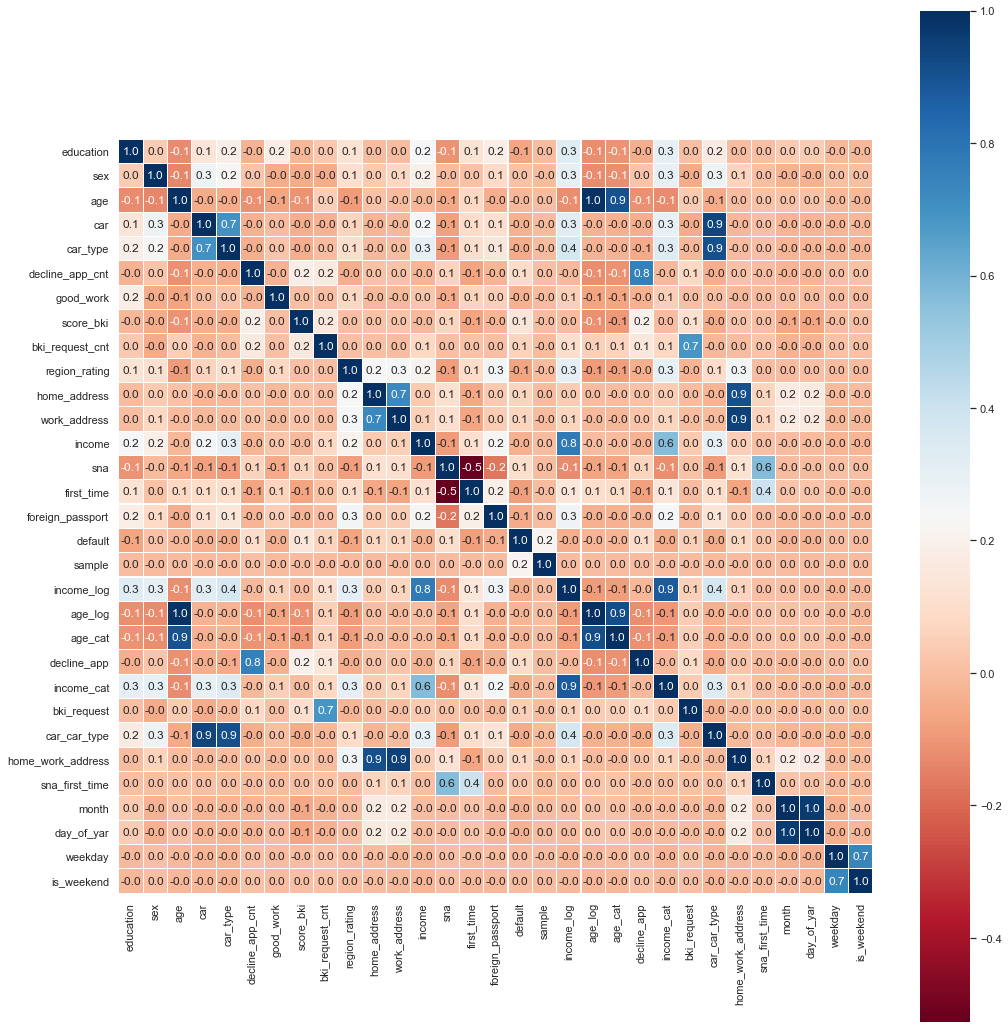

In [208]:
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(data.corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
plt.tight_layout()

Удалим коррелирующие признаки

Коррелирующие признаки: age, age_log, age_cat; car, car_type, car_car_type; 
decline_app_cnt, decline_app; bki_request_cnt, bki_request; home_address, work_address, home_work_address; income, income_log, income_cat; sna, first_time, sna_first_time; month, day_of_year; weekday, is_weekend.

In [209]:
# Корреляции предсказуемо имеются у новых признаков, с признаками на основе которых они были созданы. Однако путем экспериментов, удаление признаков ведет к ухудшению показателей подели.

In [210]:
# Удаление сильно коррелирующих переменных привело к ухудшению модели.

### Посмотрим корреляцию признаков с целевой переменной

In [211]:
abs(data.drop(['sample'], axis=1).corr()['default']).sort_values()

weekday              0.000546
is_weekend           0.003849
sex                  0.014580
age                  0.019169
age_cat              0.019827
age_log              0.020057
sna_first_time       0.027180
month                0.029169
day_of_yar           0.030918
income               0.031735
car                  0.034999
good_work            0.035126
income_log           0.043098
car_car_type         0.043679
income_cat           0.045198
car_type             0.046586
bki_request          0.050125
foreign_passport     0.052770
bki_request_cnt      0.061523
work_address         0.064733
education            0.067288
home_address         0.068008
home_work_address    0.071103
region_rating        0.071729
first_time           0.084394
decline_app_cnt      0.092455
decline_app          0.093465
sna                  0.101171
score_bki            0.139777
default              1.000000
Name: default, dtype: float64

Корреляция целевой переменной только с числовой переменной

In [212]:
abs(data[num_cols + ['default']].corr()['default']).sort_values()

age                0.019169
age_log            0.020057
day_of_yar         0.030918
income             0.031735
income_log         0.043098
bki_request_cnt    0.061523
decline_app_cnt    0.092455
score_bki          0.139777
default            1.000000
Name: default, dtype: float64

### Посмотрим значимость непрерывных переменных, с помощью f classif функции

<AxesSubplot:>

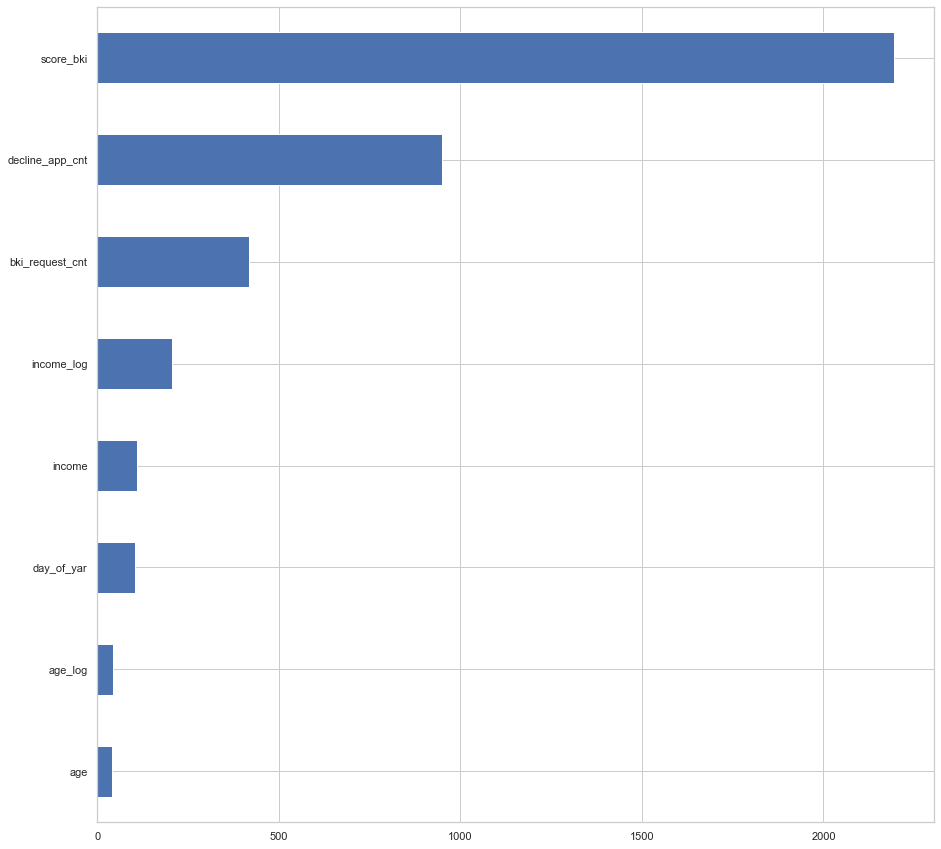

In [213]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Удаление малозначительных переменных так же приводит к ухудшению модели.

Смотрим значимость категориальных признаков с помощью функции mutual info classif

<AxesSubplot:>

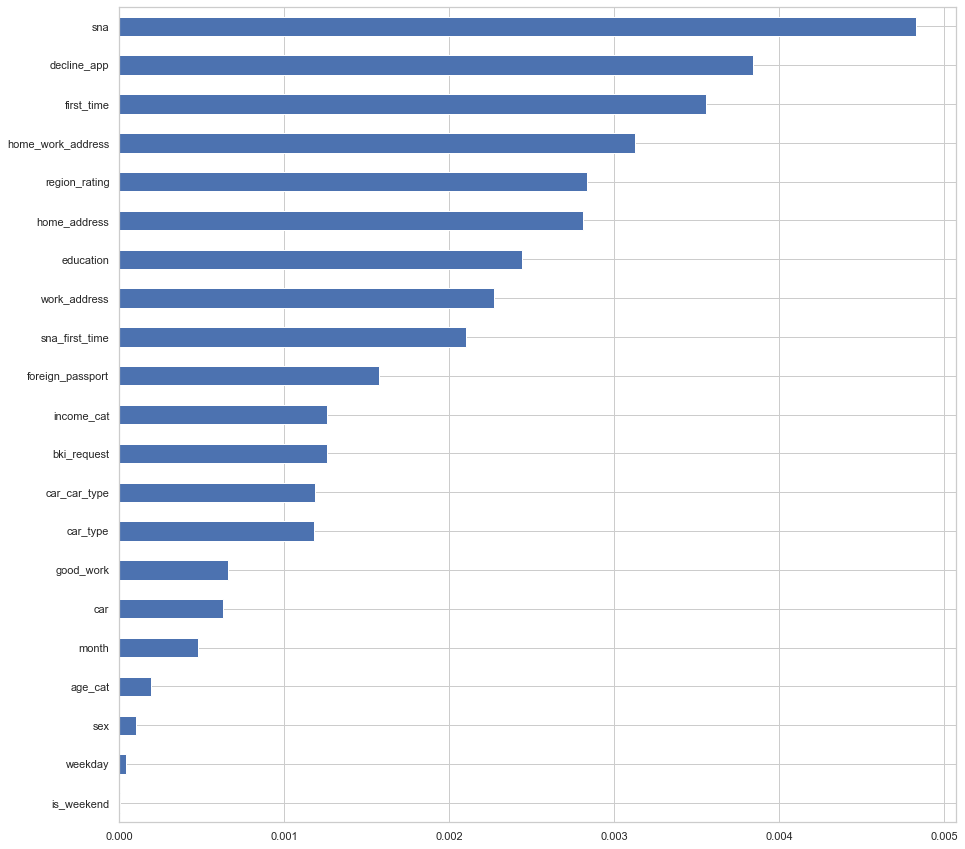

In [214]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [215]:
# from sklearn.feature_selection import GenericUnivariateSelect, chi2
# >>> X, y = load_breast_cancer(return_X_y=True)
# >>> X.shape
# (569, 30)
# >>> transformer = GenericUnivariateSelect(chi2, mode='k_best', param=20)
# >>> X_new = transformer.fit_transform(X, y)
# >>> X_new.shape
# (569, 20)

Удаление малозначительных категориальных признаков приводит к ухудшению показателей модели.

In [158]:
# delcol = ['age', 
#           'age_cat', 
#           'car', 
#           'car_car_type', 
#           'decline_app_cnt', 
#           'bki_request', 
#           'home_address', 
#           'work_address', 
#           'income', 
#           'income_log', 
#           'sna_first_time', 
#           'month', 
#           'is_weekend']

In [216]:
data1 = data.copy()

In [315]:
data = data1

In [256]:
default = pd.DataFrame(data['default'])

In [316]:
data = data.drop(['sample', 'default'], axis=1)

In [162]:
# data = data.drop(delcol, axis=1)

In [ ]:
f_classif, mutual_info_classif, chi2

In [ ]:
#cat_cols = ['education', 'region_rating', 'sna','first_time', 'income_cat', 'home_work_address', 'weekday']

Путем экспериментов выяснено, что модель работает лучше, если категориальные признаки закодировать с помощью One-Hot Encoding 

In [317]:
data = pd.get_dummies(data, columns=cat_cols)

In [318]:
y = default
data = SelectPercentile(f_classif, percentile=80).fit_transform(data, y)
data = SelectPercentile(mutual_info_classif, percentile=80).fit_transform(data, y)

In [319]:
data.shape

(110148, 47)

Добавим полиноминальные признаки, после экспериментов - модель переобучается. На тестовых данных дает 100% результат, однако на Каггле получается низкий результат

In [45]:
# poly = PolynomialFeatures(2)
# data_pol = poly.fit_transform(data[num_cols])
# data_pol = pd.DataFrame(data_pol)
# data1 = data.join(data_pol)

Выберем дискретные и числовые признаки, вместе с полиноминальными переменными, отсеем их по F-class и Mutual-info-class - так же приводит к переобучению и плхим результатам в полевых условиях.

In [46]:
# data_num = data1[num_cols + list(data_pol.columns)]
# data_dis = data1.drop(num_cols + list(data_pol.columns), axis=1)
# info_data = data1[['default', 'sample']]
# y = data.default

In [47]:
# X_dis = SelectPercentile(chi2, percentile=10).fit_transform(data_dis, y)
# X_num = SelectPercentile(f_classif, percentile=10).fit_transform(data_num, y)
# data4 = pd.DataFrame(np.hstack([X_num, X_dis]))

In [48]:
# data4 = data4.join(info_data)

# Модели

## Использовал только LogisticRegression

### В итоге лучший результат показывает LogisticRegression на всех признаках, на стандартных настройках

Пробовал на стандартизацию отправлять только числовые переменные, результат не меняется.

In [49]:
#колонки на отдельное стандартизирование(не очень сработало)
#scale_col = ['age', 'score_bki', 'bki_request_cnt', 'region_rating', 'income', 'income_log', 'age_log', 'car_car_type', 'home_work_address', 'sna_first_time', 'day_of_yar']

In [50]:
# # Теперь выделим тестовую часть с предварительной стандартизацией
# #data_scal = pd.DataFrame(StandardScaler().fit_transform(data[scale_col].values))
# #data_disc = data.drop(scale_col, axis=1)
# #data2 = data_disc.join(data_scal)
# train_data = data.query('sample == 1').drop(['sample'], axis=1)
# test_data = data.query('sample == 0').drop(['sample'], axis=1)

# y = train_data.default.values            # наш таргет
# X = train_data.drop(['default', 'client_id'], axis=1)

Пробовал undersampling, результат хуже

In [320]:
# Теперь выделим тестовую часть
data = pd.DataFrame(data)
data = data.join(client_id)
data = data.join(sample)
data = data.join(default)
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

# #undersampling работает хуже
# under_train = pd.concat([train_data[train_data['default']==0].sample(
#     len(train_data[train_data['default']==1]), 
#     random_state=RANDOM_SEED), train_data[train_data['default']==1]])
# y = under_train.default.values            # наш таргет
# X = under_train.drop(['default', 'client_id'], axis=1)


#обычная выборка
y = train_data.default.values            # наш таргет
X = train_data.drop(['default', 'client_id'], axis=1)

#X = MinMaxScaler(feature_range = (0, 1)).fit_transform(X.values)
X = StandardScaler().fit_transform(X)
#X = RobustScaler().fit_transform(X.values) сработал хуже
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Так же пробовал разные стандартизаторы, результат не менялся.

### LogisticRegression на стандартных настойках и всех данных

confusion_matrix
[[12883    50]
 [ 1788    39]]


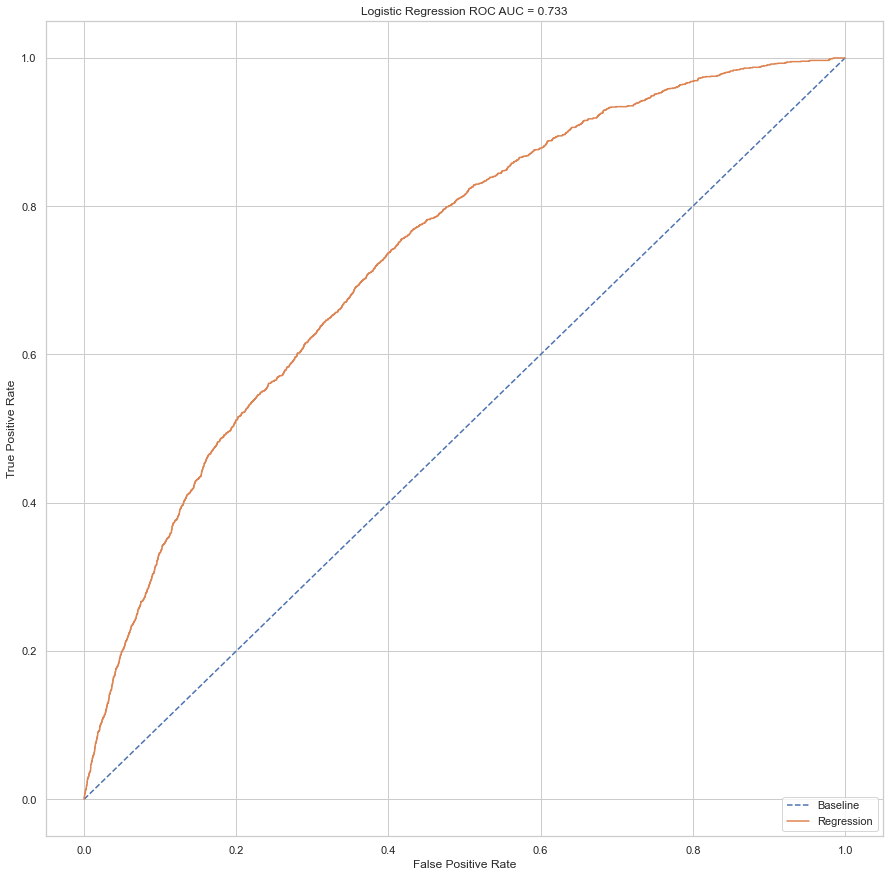

log_loss 0.33637204286333


,0,1,accuracy,macro avg,weighted avg,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos,log_loss
naive,-,-,-,-,-,-,-,-,-,-,-,-,-
precision,0.877991,0.41573,0.875203,0.64686,0.820772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recall,0.995979,0.020252,0.875203,0.508116,0.875203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f1-score,0.933271,0.038622,0.875203,0.485946,0.822531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
support,12933.0,1827.0,0.875203,14760.0,14760.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precision,0.878591,0.448598,0.875474,0.663595,0.825367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recall,0.995438,0.026273,0.875474,0.510855,0.875474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f1-score,0.933372,0.049638,0.875474,0.491505,0.823983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
support,12933.0,1827.0,0.875474,14760.0,14760.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LogisticRegression_GridCV,NaN,NaN,NaN,NaN,NaN,0.745459,0.226967,0.342926,0.940105,0.226967,0.662646,0.701149,0.608453


In [321]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('confusion_matrix', confusion_matrix(y_test, y_pred), sep='\n')

probs = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
roc_auc = roc_auc_score(y_test, probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

print('log_loss', log_loss(y_test, probs))

data_report.loc['naive'] = '-'
data_report = data_report.append(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)))
data_report

Посмотрим, не переобучется ли у нас модель

[train] F1-score = 0.73 +/- 0.00
[valid] F1-score = 0.72 +/- 0.01


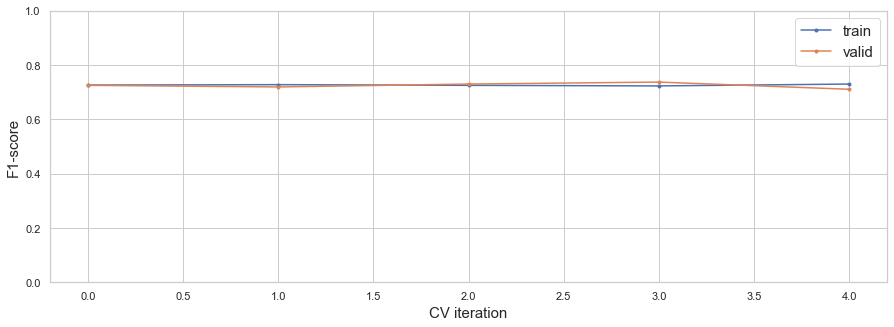

In [322]:
cv_metrics = cross_validate(model, X, y, cv=5, scoring='roc_auc', return_train_score=True)
plot_cv_metrics(cv_metrics)

Судя результатам - нет

Модель показала мой лучший результат на Каггле - 0.73989. Однако по другим метрикам мы видим сущетственный недостаток модели. по confusion matrix мы видим, что модель достаточно уверенно угадывает клиентов, которые вернут кредит, и только 2% дефолтных клиентов. Думаю, что на Каггле она угадывает несколько больше, но в любом случае, такая модель может принести большие убытки банку. Это мы так же видим по низкому показателю recall и f1-score. Причина может быть в несбалансированности выборки. Мы ее заметили еще на стадии EDA. Попробуем доработать модель.

### LogisticRegression и GridSearchCV. Попробуем подобрать лучшие гиперпараметры

In [54]:
model = LogisticRegression(max_iter=500)
class_weight = [None, 'balanced']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10]
penalty = ['l1', 'l2', None]
solver = ['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg']
# Создадим гиперпараметры
hyperparameters = dict(penalty=penalty, C=C, solver=solver, class_weight=class_weight)
Grid = GridSearchCV(model, hyperparameters, cv=4, verbose=0, scoring='roc_auc', n_jobs=4)
Grid.fit(X_train, y_train)
Grid.best_params_

C:\Users\negat\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.5               nan 0.5               nan 0.72442326
 0.72758159 0.72442378 0.72442419 0.72442416        nan        nan
        nan        nan        nan        nan 0.5               nan
 0.5               nan 0.72970125 0.72968817 0.72970035 0.72970088
 0.72970106        nan        nan        nan        nan        nan
        nan 0.69007404        nan 0.68995263        nan 0.73349733
 0.73359843 0.73349885 0.73349872 0.73349802        nan        nan
        nan        nan        nan        nan 0.71953267        nan
 0.72035125        nan 0.73403108 0.73404159 0.73403161 0.7340312
 0.73403144        nan        nan        nan        nan        nan
        nan 0.73336208        nan 0.73336434        nan 0.73389093
 0.73392858 0.73389064 0.73389102 0.73389137        nan        nan
        nan        nan        nan        nan 0.7339487

{'C': 0.001,
 'class_weight': 'balanced',
 'penalty': 'l2',
 'solver': 'liblinear'}

Пробовал различные метрики истользовать для выбора лучших параметров в GridSearchCV, roc_auc показал себя лучше

Как и планировалось выше, посковик выбрал параметр, учитывающий несбалансированность выборки - class_weight. Обучим модель на новых параметрах.

In [324]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.default.values            # наш таргет
X = train_data.drop(['default', 'client_id'], axis=1)

X = StandardScaler().fit_transform(X.values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

confusion_matrix
[[8451 4482]
 [ 583 1244]]
f1_score
0.3294055342248113
accuracy_score
0.6568428184281843
recall_score
0.6808976464148878
precision_score
0.21725462801257422


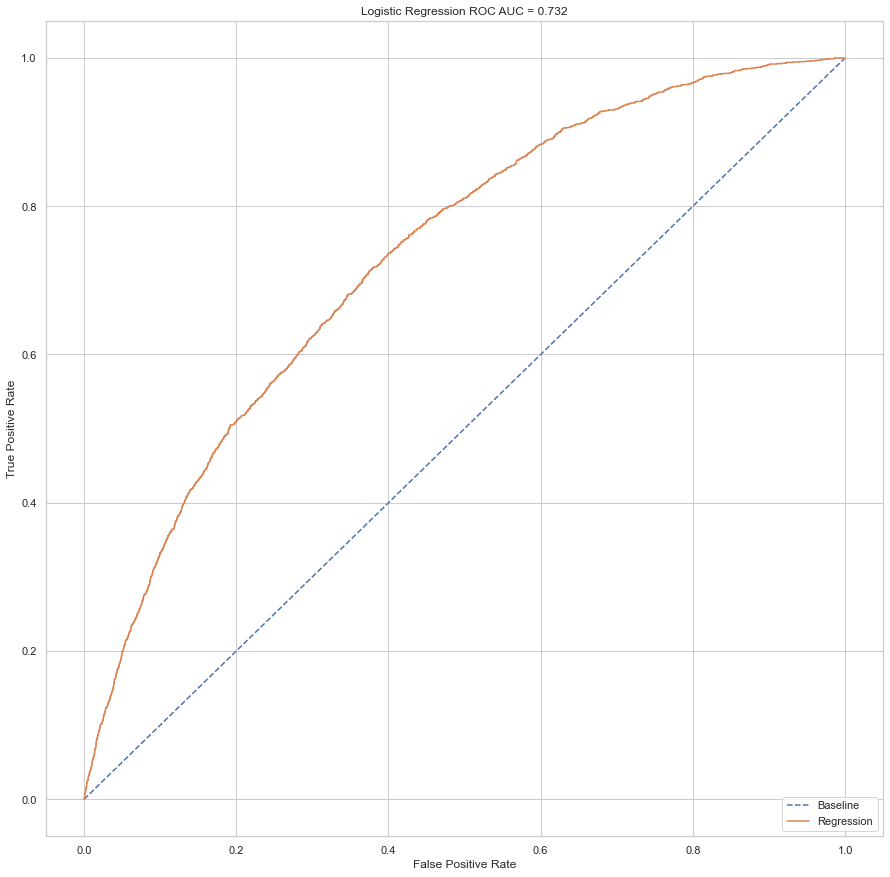

,0,1,accuracy,macro avg,weighted avg,ROC-AUC,PR-AUC,F1,precision_Neg,precision_Pos,recall_Neg,recall_Pos,log_loss
naive,-,-,-,-,-,-,-,-,-,-,-,-,-
precision,0.877991,0.41573,0.875203,0.64686,0.820772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recall,0.995979,0.020252,0.875203,0.508116,0.875203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f1-score,0.933271,0.038622,0.875203,0.485946,0.822531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
support,12933.0,1827.0,0.875203,14760.0,14760.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precision,0.878591,0.448598,0.875474,0.663595,0.825367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recall,0.995438,0.026273,0.875474,0.510855,0.875474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f1-score,0.933372,0.049638,0.875474,0.491505,0.823983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
support,12933.0,1827.0,0.875474,14760.0,14760.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LogisticRegression_GridCV,NaN,NaN,NaN,NaN,NaN,0.745459,0.226967,0.342926,0.940105,0.226967,0.662646,0.701149,0.608453


In [325]:
model = LogisticRegression(penalty='l2',
                           C=0.001,
                           class_weight='balanced',
                           solver='liblinear'
                           )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('confusion_matrix', confusion_matrix(y_test, y_pred), sep='\n')
print('f1_score', f1_score(y_test, y_pred), sep='\n')
print('accuracy_score', accuracy_score(y_test, y_pred), sep='\n')
print('recall_score', recall_score(y_test, y_pred), sep='\n')
print('precision_score', precision_score(y_test, y_pred), sep='\n')

probs = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
roc_auc = roc_auc_score(y_test, probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

#print(log_loss(y_test, probs))

data_report = get_scores(data_report, model, X_test, 
                       y_test, 'LogisticRegression_GridCV')
data_report

Посмотрим, не переобучется ли у нас модель

[train] F1-score = 0.74 +/- 0.00
[valid] F1-score = 0.74 +/- 0.01


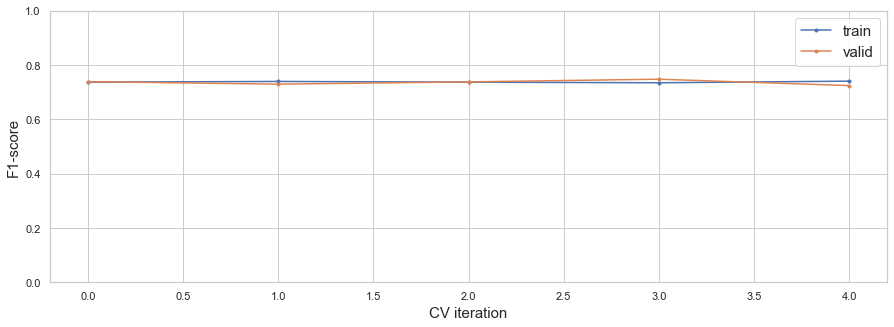

In [283]:
cv_metrics = cross_validate(model, X, y, cv=5, scoring='roc_auc', return_train_score=True)
plot_cv_metrics(cv_metrics)

Судя результатам - нет

Не смотря на то, что модель показала на Каггле результаты хуже -  0.73961, я считаю эта модель лучше справляется с задачей скоринга. Она угадывает по нашим метрикам до 70% дефолтных клиентов, хотя и теряет до 34% лояльных клиентов. Модель все еще требует доработки, возможно стояло бы попробовать более продвинутые классификаторы.

### Отправим результаты на Каггл

In [326]:
test_data = test_data.drop(['default'], axis=1)
test_client_id = pd.DataFrame()
test_client_id['client_id'] = test_data['client_id']
test_data = test_data.drop(['client_id'], axis=1)
test_data = StandardScaler().fit_transform(test_data.values)
predict_submission = model.predict_proba(test_data)
test_client_id['default'] = predict_submission[:,1]
test_client_id.to_csv('submission.csv', index=False)
test_client_id.head(10)

,client_id,default
0,74835,0.188639
1,17527,0.856801
2,75683,0.349842
3,26883,0.329717
4,28862,0.237593
5,99881,0.594919
6,26630,0.846145
7,79934,0.200452
8,16605,0.305608
9,105449,0.241858
